# TUTO Cover-Detection based on Triplet-Loss

- date: 2024-07-16
- author: geoffroy.peeters@telecom-paris.fr

code based on 
- MOVE https://arxiv.org/pdf/1910.12551 https://github.com/furkanyesiler/move


using datasets
- Cover-1000 https://www.covers1000.net/dataset.html
- DA-TACOS https://github.com/MTG/da-tacos

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import torchaudio
from torch.utils.data import Dataset
import torch.optim as optim


import lightning.pytorch as pl
from lightning.pytorch.callbacks import Callback
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

import wandb
from pytorch_lightning.loggers import WandbLogger

import json
import h5py
import pprint as pp
from tqdm import tqdm
import datetime
from argparse import Namespace


import librosa
import matplotlib.pyplot as plt
import numpy as np

from argparse import Namespace

OSError: dlopen(/Users/peeters/opt/anaconda3/lib/python3.8/site-packages/torchaudio/lib/libtorchaudio.so, 6): Symbol not found: __ZNK3c104Type14isSubtypeOfExtERKNSt3__110shared_ptrIS0_EEPNS1_13basic_ostreamIcNS1_11char_traitsIcEEEE
  Referenced from: /Users/peeters/opt/anaconda3/lib/python3.8/site-packages/torchaudio/lib/libtorchaudio.so
  Expected in: /Users/peeters/opt/anaconda3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib
 in /Users/peeters/opt/anaconda3/lib/python3.8/site-packages/torchaudio/lib/libtorchaudio.so

In [115]:
ROOT = '/tsi/data_doctorants/gpeeters/_data/'
base = 'cover1000'
#base = 'datacos-benchmark'

pyjama_annot_file = f'{ROOT}/{base}.pyjama'
hdf5_feat_file = f'{ROOT}/{base}_feat.hdf5'

with open(pyjama_annot_file, encoding = "utf-8") as json_fid:
    data_d = json.load(json_fid)
audiofile_l = [entry['filepath'][0]['value'] for entry in data_d['collection']['entry']]

with h5py.File(hdf5_feat_file, 'r') as hdf5_fid:
    print(hdf5_fid['/'].keys())
    #for idx, audio_file in enumerate(audiofile_l):
    #    print(f"{idx} shape: {hdf5_fid[audio_file].shape}")


<KeysViewHDF5 ['100259', '100444', '100445', '100977', '100978', '10118', '10119', '101628', '101988', '10255', '10339', '103484', '103816', '105462', '105475', '105666', '105979', '107456', '108638', '108887', '108889', '109014', '109016', '1091', '10985', '110690', '110944', '11129', '11130', '111805', '111994', '112723', '112724', '112885', '114871', '11579', '115846', '115847', '11591', '116937', '116947', '116948', '116950', '117290', '117291', '117560', '117561', '117837', '118446', '120242', '120243', '120700', '12174', '123058', '12396', '124152', '126122', '126344', '126867', '126868', '128413', '128891', '128894', '1298', '129901', '129902', '13048', '13110', '131132', '13134', '131709', '132716', '133360', '134373', '135909', '136091', '136463', '137850', '137851', '137985', '143720', '14444', '14474', '144746', '145985', '147843', '147845', '147896', '148228', '148555', '149756', '149761', '14977', '14978', '15045', '15046', '150936', '150972', '152045', '15248', '15249', '

## Parameters

In [116]:
from argparse import Namespace
param_d = Namespace()

param_d.num_of_labels = 16

param_d.emb_size = 32   #16000
param_d.sum_method = 4
param_d.final_activation = 3
param_d.downsampling_parameters = 2

param_d.margin =  1.0
param_d.mining_strategy = 1
param_d.norm_dist = 1
param_d.lr = 0.1
param_d.momentum = 0
param_d.nb_epoch = 100

param_d.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(param_d.device)


cuda:0


## Get dataloader

In [117]:
with open(pyjama_annot_file, encoding = "utf-8") as json_fid: data_d = json.load(json_fid)
entry_l = data_d['collection']['entry']
performanceid_l  = set([entry['performance-id'][0]['value'] for entry in entry_l])
len(performanceid_l)

996

In [118]:
class CoverDataset(Dataset):
    """
    description
    """

    def __init__(self, hdf5_feat_file, pyjama_annot_file, do_train):
        
        self.h = 23
        self.w = 1800
        
        with open(pyjama_annot_file, encoding = "utf-8") as json_fid: data_d = json.load(json_fid)
        entry_l = data_d['collection']['entry']

        #entry_l = entry_l[:1000]

        all_workid_l  = list(set([entry['work-id'][0]['value'] for entry in entry_l]))
        performanceid_l  = set([entry['performance-id'][0]['value'] for entry in entry_l])

        self.do_train = do_train
        if self.do_train:   workid_l = [all_workid_l[idx] for idx in range(len(all_workid_l)) if (idx % 5) != 0]
        else:               workid_l = [all_workid_l[idx] for idx in range(len(all_workid_l)) if (idx % 5) == 0]

        self.workid_to_perfomanceid_d = {}
        for workid in workid_l:
            self.workid_to_perfomanceid_d[workid] = [entry['performance-id'][0]['value'] for entry in entry_l if entry['work-id'][0]['value']==workid]

        self.clique_list_l = []
        for workid in self.workid_to_perfomanceid_d.keys():
            # --- check the number of performanceid for each workid
            # --- if this number is large this workid will be present in many clique
            nb_performanceid = len(self.workid_to_perfomanceid_d[workid])
            if nb_performanceid < 2:     pass
            elif nb_performanceid < 6:   self.clique_list_l.extend([workid] * 1)
            elif nb_performanceid < 10:  self.clique_list_l.extend([workid] * 2)
            elif nb_performanceid < 14:  self.clique_list_l.extend([workid] * 3)
            else:                       self.clique_list_l.extend([workid] * 4)

        self.data_d = {}
        with h5py.File(hdf5_feat_file, 'r') as feat_fid:
            for workid in self.workid_to_perfomanceid_d.keys():
                # --- get the list of performanceid assoicated to this workid
                perfomanceid_l = self.workid_to_perfomanceid_d[workid]
                for perfomanceid in perfomanceid_l:
                    self.data_d[perfomanceid] = {}
                    self.data_d[perfomanceid]['workid'] = workid
                    self.data_d[perfomanceid]['perfomanceid'] = perfomanceid
                    # --- Get data and convert to make rotation invariant -> self.data_d (1, 23, 1800)
                    data = torch.from_numpy(feat_fid['/' +  str(perfomanceid) + '/'][:].T).unsqueeze(0)
                    self.data_d[perfomanceid]['value'] = torch.concatenate((data, data), dim=1)[:,:-1,:]
                
    def __len__(self):
        return len(self.clique_list_l)
    
    def getitem_by_performanceid(self, perfomanceid):
        item = self.data_d[perfomanceid]['value']
        # if the song is longer than the required width, choose a random start point to crop
        if item.shape[2] >= self.w: item = item[:, :, 0:self.w]
        else:                       item = torch.cat((item, torch.zeros([1, self.h, self.w - item.shape[2]])), 2)
        return item, self.data_d[perfomanceid]['workid']

    def __getitem__(self, clique_idx):
        
        workid = self.clique_list_l[clique_idx]  # getting the clique chosen by the dataloader

        # selecting 4 songs from the given clique
        if len(self.workid_to_perfomanceid_d[workid]) == 2:  # if the clique size is 2, repeat the already selected songs
            idx1, idx2 = np.random.choice(self.workid_to_perfomanceid_d[workid], 2, replace=False)
            idx3, idx4 = idx1, idx2
        elif len(self.workid_to_perfomanceid_d[workid]) == 3:  # if the clique size is 3, choose one of the songs twice
            idx1, idx2, idx3 = np.random.choice(self.workid_to_perfomanceid_d[workid], 3, replace=False)
            idx4 = np.random.choice(self.workid_to_perfomanceid_d[workid], 1, replace=False)[0]
        else:  # if the clique size is larger than or equal to 4, choose 4 songs randomly
            idx1, idx2, idx3, idx4 = np.random.choice(self.workid_to_perfomanceid_d[workid], 4, replace=False)
        
        items = []
        for idx in [idx1, idx2, idx3, idx4]:
            item, _ = self.getitem_by_performanceid(idx)
            items.append(item)
        
        return torch.stack(items, 0), workid

In [119]:
def triplet_mining_collate(batch):
    """
    Custom collate function for triplet mining
    :param batch: elements of the mini-batch (pcp features and labels)
    :return: collated elements
    """
    items = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    return torch.cat(items, 0), labels

In [120]:
train_set = CoverDataset(hdf5_feat_file, pyjama_annot_file, do_train=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=param_d.num_of_labels, shuffle=True, collate_fn=triplet_mining_collate, drop_last=True)

valid_set = CoverDataset(hdf5_feat_file, pyjama_annot_file, do_train=False)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=param_d.num_of_labels, shuffle=False, collate_fn=triplet_mining_collate, drop_last=True)

torch.Size([4, 1, 23, 1800])
2
torch.Size([64, 1, 23, 1800])
[303, 227, 42, 184, 368, 64, 295, 334, 93, 348, 80, 372, 109, 282, 132, 318]


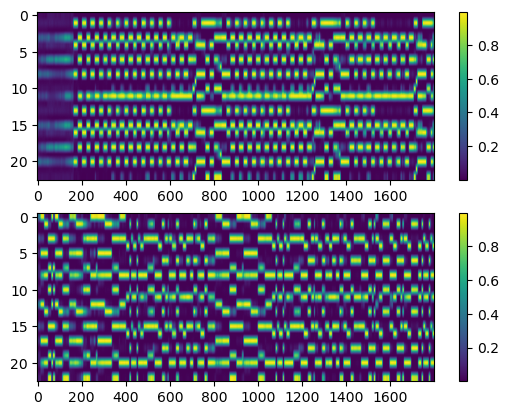

In [123]:
items, label = train_set[0]
print(items.size())
print(label)

items, labels = next(iter(train_loader))
print(items.size())
print(labels)
plt.subplot(211); plt.imshow(items[0,0,:,:].cpu().numpy(), aspect='auto'); plt.colorbar();
plt.subplot(212); plt.imshow(items[16,0,:,:].cpu().numpy(), aspect='auto'); plt.colorbar();

## Get model

In [124]:
class MOVEModel(nn.Module):
    """
    Model object for MOVE.
    The explanation of the design choices can be found at https://arxiv.org/abs/1910.12551.
    """

    def __init__(self, param_d):
        """
        Initializing the network
        :param emb_size: the size of the final embeddings produced by the model
        :param sum_method: the summarization method for the model
        :param final_activation: final activation to use for the model
        """
        super().__init__()

        self.prelu1 = nn.PReLU(init=0.01)
        self.prelu2 = nn.PReLU(init=0.01)
        self.prelu3 = nn.PReLU(init=0.01)
        self.prelu4 = nn.PReLU(init=0.01)
        self.prelu5 = nn.PReLU(init=0.01)

        N = 4
        self.n1 = int(256/param_d.downsampling_parameters)
        self.n2 = int(256/param_d.downsampling_parameters)
        self.n3 = int(256/param_d.downsampling_parameters)
        self.n4 = int(256/param_d.downsampling_parameters)
        if param_d.sum_method in [0, 1, 2]: 
            self.n5 = int(256/param_d.downsampling_parameters)
            self.n6 = self.n5
        else:
            self.n5 = int(512/param_d.downsampling_parameters)
            self.n6 = int(self.n5/2)
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.n1, kernel_size=(12, 180), bias=True)
        nn.init.kaiming_normal_(self.conv1.weight, a=0.01, mode='fan_in', nonlinearity='leaky_relu')

        self.key_pool = nn.MaxPool2d(kernel_size=(12, 1))

        self.conv2 = nn.Conv2d(in_channels=self.n1, out_channels=self.n2, kernel_size=(1, 5), bias=True)
        nn.init.kaiming_normal_(self.conv2.weight, a=0.01, mode='fan_in', nonlinearity='leaky_relu')

        self.conv3 = nn.Conv2d(in_channels=self.n2, out_channels=self.n3, kernel_size=(1, 5), dilation=(1, 20), bias=True)
        nn.init.kaiming_normal_(self.conv3.weight, a=0.01, mode='fan_in', nonlinearity='leaky_relu')

        self.conv4 = nn.Conv2d(in_channels=self.n3, out_channels=self.n4, kernel_size=(1, 5), bias=True)
        nn.init.kaiming_normal_(self.conv4.weight, a=0.01, mode='fan_in', nonlinearity='leaky_relu')

        self.conv5 = nn.Conv2d(in_channels=self.n4, out_channels=self.n5, kernel_size=(1, 5), dilation=(1, 13), bias=True)
        nn.init.kaiming_normal_(self.conv5.weight, a=0.01, mode='fan_in', nonlinearity='leaky_relu')

        self.fin_emb_size = param_d.emb_size
        self.autopool_p = nn.Parameter(torch.tensor(0.).float())
        self.sum_method = param_d.sum_method
        self.final_activation = param_d.final_activation


        lin_bias = True
        if self.final_activation == 3:
            self.lin_bn = nn.BatchNorm1d(param_d.emb_size, affine=False)
            lin_bias = False

        self.lin1 = nn.Linear(in_features=self.n6, out_features=param_d.emb_size, bias=lin_bias)

    def forward(self, data):
        """
        Defining a forward pass of the network
        :param data: input tensor for the network
        :return: output tensor
        """
        
        # --- data (batch, dim=23, time=1800)

        x = self.prelu1(self.conv1(data))
        x = self.key_pool(x)
        
        x = self.prelu2(self.conv2(x))
        x = self.prelu3(self.conv3(x))
        x = self.prelu4(self.conv4(x))
        x = self.prelu5(self.conv5(x))
        
        if self.sum_method == 0:
            x = torch.max(x, dim=3, keepdim=True).values
        elif self.sum_method == 1:
            x = torch.mean(x, dim=3, keepdim=True)
        elif self.sum_method == 2:
            # --- weights are computed using autopool and the same channels 
            weights = self.autopool_weights(x)
            x = torch.sum(x * weights, dim=3, keepdim=True)
        elif self.sum_method == 3:
            # --- weights are computed using softmax and the first 256 channels
            weights = torch.nn.functional.softmax(x[:, 256:], dim=3)
            x = torch.sum(x[:, :256] * weights, dim=3, keepdim=True)
        else:
            # --- weights are computed using autopool and the first 256 channels
            weights = self.autopool_weights(x[:, :int(self.n5/2)])
            x = torch.sum(x[:, int(self.n5/2):] * weights, dim=3, keepdim=True)

        x = x.view(-1, self.n6)
        x = self.lin1(x)

        if self.final_activation == 1:      x = torch.sigmoid(x)
        elif self.final_activation == 2:    x = torch.tanh(x)
        elif self.final_activation == 3:    x = self.lin_bn(x)
        else:                               x = x

        return x

    def autopool_weights(self, data):
        """
        Calculating the autopool weights for a given tensor
        :param data: tensor for calculating the softmax weights with autopool
        :return: softmax weights with autopool

        see https://arxiv.org/pdf/1804.10070
        alpha=0: unweighted mean
        alpha=1: softmax
        alpha=inf: max-pooling
        """
        # --- x: (batch, 256, 1, T)
        x = data * self.autopool_p
        # --- max_values: (batch, 256, 1, 1)
        max_values = torch.max(x, dim=3, keepdim=True).values
        # --- softmax (batch, 256, 1, T)
        softmax = torch.exp(x - max_values)
        # --- weights (batch, 256, 1, T)
        weights = softmax / torch.sum(softmax, dim=3, keepdim=True)

        return weights

In [125]:
move_model = MOVEModel(param_d).to(param_d.device)
data, label = next(iter(train_loader))
print(move_model(data.to(param_d.device)).size())

import torchsummary
torchsummary.summary(move_model, (1, 23, 1800))

torch.Size([64, 32])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 12, 1621]         276,608
             PReLU-2        [-1, 128, 12, 1621]               1
         MaxPool2d-3         [-1, 128, 1, 1621]               0
            Conv2d-4         [-1, 128, 1, 1617]          82,048
             PReLU-5         [-1, 128, 1, 1617]               1
            Conv2d-6         [-1, 128, 1, 1537]          82,048
             PReLU-7         [-1, 128, 1, 1537]               1
            Conv2d-8         [-1, 128, 1, 1533]          82,048
             PReLU-9         [-1, 128, 1, 1533]               1
           Conv2d-10         [-1, 256, 1, 1481]         164,096
            PReLU-11         [-1, 256, 1, 1481]               1
           Linear-12                   [-1, 32]           4,096
      BatchNorm1d-13                   [-1, 32]               0
Total params: 690,

## Define losses

In [126]:
def pairwise_distance_matrix(x, y=None, eps=1e-12):
    """
    Calculating squared euclidean distances between the elements of two tensors
    :param x: first tensor
    :param y: second tensor (optional)
    :param eps: epsilon value for avoiding div by zero
    :return: pairwise distance matrix
    """
    x_norm = x.pow(2).sum(dim=1).view(-1, 1)
    if y is not None:
        y_norm = y.pow(2).sum(dim=1).view(1, -1)
    else:
        y = x
        y_norm = x_norm.view(1, -1)

    dist = x_norm + y_norm - 2 * torch.mm(x, y.t().contiguous())
    return torch.clamp(dist, eps, np.inf)

In [127]:
def f_renumber(labels):
    """
    renumber the labels (which correspond to work-id) starting from 0 and get 4 of them each time
    """
    aux = {}
    i_labels = []
    for l in labels:
        if l not in aux:
            aux[l] = len(aux)
        i_labels += [aux[l]]*4
    return i_labels

f_renumber(['W_300', 'W_200', 'W_500', 'W_300'])

[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0]

In [128]:
def triplet_loss_mining(embedding_m, labels, param_d):
    """
    Online mining function for selecting the triplets
    """

    batch_size = embedding_m.size(0)

    # creating positive and negative masks for online mining
    i_labels = f_renumber(labels)
    i_labels = torch.Tensor(i_labels).view(-1, 1).to(param_d.device)
    # --- get a ones matrix with zero on main diagonal (to avoid selecting the anchor itself for positive or negative)
    mask_diag = (1 - torch.eye(batch_size)).long().to(param_d.device)
    # --- the mask with 1 if same work-id 0 otherwise
    sameworkid_mask = (pairwise_distance_matrix(i_labels) < 0.5).long()
    # --- same work-id but not the anchor
    mask_pos = mask_diag * sameworkid_mask
    # --- different work-id and not the anchor
    mask_neg = mask_diag * (1 - mask_pos)

    # getting the pairwise distance matrix
    dist_all = pairwise_distance_matrix(embedding_m)  
    # normalizing the distances by the embedding size
    if param_d.norm_dist == 1:  dist_all /= param_d.emb_size

    if param_d.mining_strategy == 0:    dist_pos, dist_neg = triplet_mining_random(dist_all, mask_pos, mask_neg)
    elif param_d.mining_strategy == 1:  dist_pos, dist_neg = triplet_mining_semihard(dist_all, mask_pos, mask_neg, param_d.margin)
    else:                               dist_pos, dist_neg = triplet_mining_hard(dist_all, mask_pos, mask_neg, param_d.device)
    
    loss = F.relu(dist_pos + (param_d.margin - dist_neg))  # calculating triplet loss
    
    nb1 = torch.sum(dist_pos+param_d.margin < dist_neg).item()
    nb2 = torch.sum(loss > 0).item()

    #print(f'ok:{nb1}/used:{nb2}/total:{batch_size} \t loss:{loss.mean().item()}' )
    
    return loss.mean(), nb1#loss.sum()/nb2, nb1


def triplet_mining_random(dist_all, mask_pos, mask_neg):
    """
    Performs online random triplet mining
    """
    # selecting the positive elements of triplets
    # we consider each row as an anchor and takes the maximum of the masked row (mask_pos) as the positive
    _, sel_pos = torch.max(mask_pos.float() + torch.rand_like(dist_all), dim=1)
    dists_pos = torch.gather(input=dist_all, dim=1, index=sel_pos.view(-1, 1))
    
    # selecting the negative elements of triplets
    # we consider each row as an anchor and takes the maximum of the masked row (mask_neg) as the negative
    _, sel_neg = torch.max(mask_neg.float() + torch.rand_like(dist_all), dim=1)
    dists_neg = torch.gather(input=dist_all, dim=1, index=sel_neg.view(-1, 1))

    return dists_pos, dists_neg


def triplet_mining_semihard(dist_all, mask_pos, mask_neg, margin):
    """
    Performs online semi-hard triplet mining (a random positive, a semi-hard negative)
    """

    # --- the code below seems wrong
    # --- need criteria
    # 1) should be negative (should be from a different work-id)
    # 2) should be P < N < P+margin

    # selecting the positive elements of triplets
    # we consider each row as an anchor and takes the maximum of the masked row (mask_pos) as the positive
    _, sel_pos = torch.max(mask_pos.float() + torch.rand_like(dist_all), dim=1)
    dists_pos = torch.gather(input=dist_all, dim=1, index=sel_pos.view(-1, 1))
    
    # selecting the negative elements of triplets
    _, sel_neg = torch.max( 
                            (mask_neg + mask_neg * (dist_all < (dists_pos.expand_as(dist_all)).long()+margin)).float() 
                           + torch.rand_like(dist_all), 
                           dim=1)

    dists_neg = torch.gather(input=dist_all, dim=1, index=sel_neg.view(-1, 1))

    return dists_pos, dists_neg


def triplet_mining_hard(dist_all, mask_pos, mask_neg, device):
    """
    Performs online hard triplet mining (both positive and negative)
    """

    # --- the code below seems wrong
    # --- need criteria
    # 1) should be negative (from a different work-id)
    # 2) should be N < P

    # selecting the positive elements of triplets
    # --- for each anchor (row) we take the positive with the largest distance
    _, sel_pos = torch.max(dist_all * mask_pos.float(), 1)
    dists_pos = torch.gather(input=dist_all, dim=1, index=sel_pos.view(-1, 1))

    # modifying the negative mask for hard mining (because we will use the min)
    # --- if mask_neg==0 then inf   
    # --- if mask_neg==1 then 1
    true_value = torch.tensor(float('inf'), device=device)
    false_value = torch.tensor(1., device=device)
    mask_neg = torch.where(mask_neg == 0, true_value, false_value)
    # selecting the negative elements of triplets
    # --- for each anchor (row) we take the negative with the smallest distance
    _, sel_neg = torch.min(dist_all + mask_neg.float(), dim=1)
    dists_neg = torch.gather(input=dist_all, dim=1, index=sel_neg.view(-1, 1))

    return dists_pos, dists_neg

## Training using torchlightning

In [129]:
train_config_d = {}
project_name = 'wandb_cover'
current_datetime = datetime.datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d-%H-%M-%S")
expe_name = formatted_datetime
print(expe_name)
WORK_DIR = './'
wandb.finish()
wandb_logger = WandbLogger(project = project_name, name = expe_name, save_dir = WORK_DIR )
wandb_logger.experiment.config.update(train_config_d)

2024-07-18-15-41-08


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,██▆█▅▆▆▅▇▅▄▆▆▄▄▃▁▅▅▅▃▄▃▃▃▄▆▄▄▃▂▆▁▃▃▃▄▄▃▃
train_oktriplet,▂▁▁▁▃▂▁▁▃▃▃▂▁▄▂▃▅▂▃▄▆▅▂▄▁▄▁▁▄▃▇▃█▄▇▃▃▃▂▅
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_loss,█▄▃▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
valid_oktriplet,▁▃▃▄▄▄▅▃▄▄▄▄▅▆▅▆▅▆▅▆▅▆▄▅▇▆▇▆▆▆▆▇▆▇█▆▇▄▆█
epoch,88
train_loss,0.90665
train_oktriplet,5.0
trainer/global_step,12999
valid_loss,0.92398


In [130]:
class CoverLigthing(pl.LightningModule):
    def __init__(self, in_model):
        super().__init__()
        self.model = in_model
        self.loss = nn.BCEWithLogitsLoss()

    def training_step(self, batch, batch_idx):
        items, labels = batch
        embedding_m = move_model(items.to(param_d.device))
        loss, oktriplet = triplet_loss_mining(embedding_m, labels, param_d)
        self.log("train_loss", loss)
        self.log("train_oktriplet", oktriplet)
        return loss

    def validation_step(self, batch, batch_idx):
        items, labels = batch
        embedding_m = move_model(items.to(param_d.device))
        loss, oktriplet = triplet_loss_mining(embedding_m, labels, param_d)
        self.log("valid_loss", loss)
        self.log("valid_oktriplet", oktriplet)
         
    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=param_d.lr, momentum=param_d.momentum)
        return optimizer
    

move_model = MOVEModel(param_d).to(param_d.device)

my_lighting = CoverLigthing(move_model)
early_stop_callback = EarlyStopping(monitor="valid_loss", patience=50, verbose=True, mode="min")
checkpoint_callback = ModelCheckpoint(monitor='valid_loss', dirpath='model_cover/', filename='best_model', save_top_k=1, mode='min')
trainer = pl.Trainer(accelerator="gpu",  logger = wandb_logger, max_epochs = 500, callbacks = [early_stop_callback, checkpoint_callback])
trainer.fit(model=my_lighting, train_dataloaders=train_loader, val_dataloaders=valid_loader)

/home/ids/gpeeters/anaconda3/envs/conda_gpeeters_2024/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ids/gpeeters/anaconda3/envs/conda_gpeeters_202 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ids/gpeeters/anaconda3/envs/conda_gpeeters_2024/lib/python3.8/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /home/ids/gpeeters/model_cover exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | MOVEModel         | 690 K 
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
690 K     Trainable params
0         Non-trainable params
690 K     Total params
2.764     Total estimated model params size (MB)


/home/ids/gpeeters/anaconda3/envs/conda_gpeeters_2024/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/ids/gpeeters/anaconda3/envs/conda_gpeeters_2024/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/ids/gpeeters/anaconda3/envs/conda_gpeeters_2024/lib/python3.8/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.

Epoch 0: 100%|██████████| 19/19 [00:02<00:00,  6.45it/s, v_num=on2g]

Metric valid_loss improved. New best score: 0.863


Epoch 1: 100%|██████████| 19/19 [00:01<00:00, 11.79it/s, v_num=on2g]

Metric valid_loss improved by 0.134 >= min_delta = 0.0. New best score: 0.729


Epoch 2: 100%|██████████| 19/19 [00:01<00:00, 11.75it/s, v_num=on2g]

Metric valid_loss improved by 0.044 >= min_delta = 0.0. New best score: 0.685


Epoch 4: 100%|██████████| 19/19 [00:01<00:00, 11.51it/s, v_num=on2g]

Metric valid_loss improved by 0.088 >= min_delta = 0.0. New best score: 0.597


Epoch 8: 100%|██████████| 19/19 [00:01<00:00, 11.68it/s, v_num=on2g]

Metric valid_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.570


Epoch 13: 100%|██████████| 19/19 [00:01<00:00, 11.62it/s, v_num=on2g]

Metric valid_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.544


Epoch 15: 100%|██████████| 19/19 [00:01<00:00, 11.60it/s, v_num=on2g]

Metric valid_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.534


Epoch 22: 100%|██████████| 19/19 [00:01<00:00, 11.63it/s, v_num=on2g]

Metric valid_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.528


Epoch 26: 100%|██████████| 19/19 [00:01<00:00, 11.63it/s, v_num=on2g]

Metric valid_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.525


Epoch 29: 100%|██████████| 19/19 [00:01<00:00, 11.59it/s, v_num=on2g]

Metric valid_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.514


Epoch 33: 100%|██████████| 19/19 [00:01<00:00, 11.61it/s, v_num=on2g]

Metric valid_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.505


Epoch 42: 100%|██████████| 19/19 [00:01<00:00, 11.42it/s, v_num=on2g]

Metric valid_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.502


Epoch 50: 100%|██████████| 19/19 [00:01<00:00, 11.59it/s, v_num=on2g]

Metric valid_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.488


Epoch 52:  32%|███▏      | 6/19 [00:00<00:00, 13.92it/s, v_num=on2g] 

/home/ids/gpeeters/anaconda3/envs/conda_gpeeters_2024/lib/python3.8/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


## Testing

In [131]:
test_set = CoverDataset(hdf5_feat_file, pyjama_annot_file, do_train=False)

In [132]:
move_model.to(param_d.device)
with torch.no_grad():
    move_model.eval()
    embed_all_m = torch.tensor([], device=param_d.device)
    coverid_l = []
    performanceid_l = []
    for performanceid in test_set.data_d.keys():
        items, coverid = test_set.getitem_by_performanceid(performanceid)
        embedding_m = move_model(items.unsqueeze(0).to(param_d.device))
        embed_all_m = torch.cat((embed_all_m, embedding_m), dim=0) 
        coverid_l.append(coverid)
        performanceid_l.append(performanceid)
        
dist_all_m = pairwise_distance_matrix(embed_all_m)
if param_d.norm_dist == 1:  dist_all_m /= param_d.emb_size


#### Compute Ranking Metrics

https://gist.github.com/bwhite/3726239

In [133]:
def F_mean_rank(relevance):
    return relevance.nonzero()[0][0]+1

def F_mean_reciprocal_rank(relevance):
    return 1./ F_mean_rank(relevance)

def F_precision_at_k(relevance, k):
    return np.mean(relevance[:k] != 0)

def F_average_precision(relevance):
    out = [F_precision_at_k(relevance, k + 1) for k in range(relevance.size) if relevance[k]]
    return np.mean(out)

dist_all_np = dist_all_m.cpu().numpy()
nb_target = dist_all_np.shape[0]
dist_all_np += 1e6*np.eye(nb_target) # --- to prevent detecting the target itself
mean_rank_l, mean_reciprocal_rank_l, precision_at_1_l, precision_at_5_l, precision_at_10_l, average_precision_l = [], [], [], [], [], []

score_d = {}
for key in ['mean_rank', 'mean_reciprocal_rank', 'precision_at_1','precision_at_5', 'precision_at_10', 'average_precision']:
    score_d[key] = [] 

for idx_target in range(nb_target):
    relevance = np.asarray([1 if coverid_l[pos]==coverid_l[idx_target] else 0 for pos in np.argsort(dist_all_np[idx_target,:])])    
    score_d['mean_rank'].append( F_mean_rank(relevance) )
    score_d['mean_reciprocal_rank'].append( F_mean_reciprocal_rank(relevance) )
    score_d['precision_at_1'].append( F_precision_at_k(relevance, 1) )
    score_d['precision_at_5'].append( F_precision_at_k(relevance, 5) )
    score_d['precision_at_10'].append( F_precision_at_k(relevance, 10) )
    score_d['average_precision'].append( F_precision_at_k(relevance, 10) )
    
for key in score_d.keys():
    print(f"{key}: {np.mean(np.asarray(score_d[key]))}")

mean_rank: 10.755
mean_reciprocal_rank: 0.5941661194043436
precision_at_1: 0.495
precision_at_5: 0.19
precision_at_10: 0.10900000000000003
average_precision: 0.10900000000000003
